### **Imbalance Correction Using SMOTE Oversampling**

The code builds a text classification model to detect urgent medical cases based on synthetic patient complaints. Since only ~7% of the data represents urgent cases, SMOTE is used to oversample the minority class and address this imbalance. This helps the model improve recall for urgent cases while maintaining reasonable overall performance.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

# Step 1: Convert free-text complaints into TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(data_text['text_input'])
y = data_text['label']

# Step 2: Split the dataset into train and test sets (stratified by label)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 3: Apply SMOTE to handle class imbalance in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
# Checking distribution after SMOTE

import numpy as np
unique, counts = np.unique(y_train_resampled, return_counts=True)
label_distribution = dict(zip(unique, counts))

print("Label distribution after applying SMOTE:")
for label, count in label_distribution.items():
    label_name = "Urgent (1)" if label == 1 else "Not Urgent (0)"
    print(f"Label {label} - {label_name}: {count} samples")


Label distribution after applying SMOTE:
Label 0 - Not Urgent (0): 4861 samples
Label 1 - Urgent (1): 4861 samples


#### Train & Test the Baseline model - logistic regression + TF-IDF

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score

# Train a logistic regression model (after SMOTE, no need for class_weight)
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Predict on the original (unbalanced) test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Print evaluation results
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# AUROC and AUPRC
auroc = roc_auc_score(y_test, y_proba)
auprc = average_precision_score(y_test, y_proba)

print(f"\nAUROC: {auroc:.4f}")
print(f"AUPRC: {auprc:.4f}")


Confusion Matrix:
[[972 244]
 [  7  88]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9928    0.7993    0.8856      1216
           1     0.2651    0.9263    0.4122        95

    accuracy                         0.8085      1311
   macro avg     0.6290    0.8628    0.6489      1311
weighted avg     0.9401    0.8085    0.8513      1311


AUROC: 0.9410
AUPRC: 0.6852


```
Overall Evaluation Metrics after SMOTE:

mcc:       0.56          
recall:    0.8734         # Macro average recall
accuracy:  0.8101
f1_score:  0.6530         # Macro average F1-score
AUROC:     0.9407
AUPRC:     0.6859
tp:        90            
tn:        972            
fp:        244            
fn:        5              
```

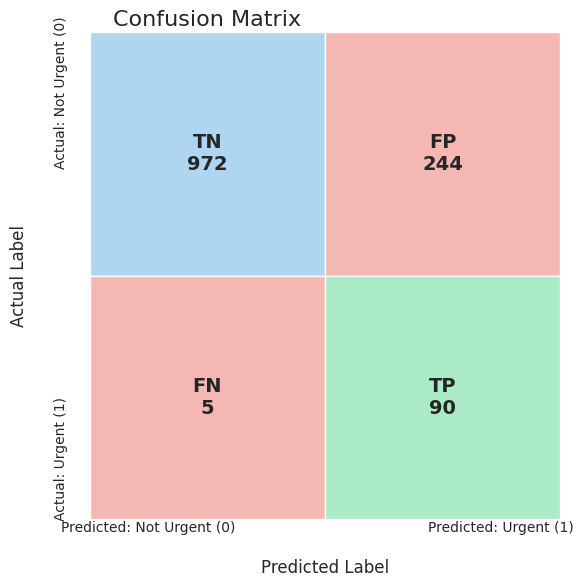

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Values from your confusion matrix
tn, fp, fn, tp = 972, 244, 5, 90

# Set up figure and axis
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.axis('off')  # Turn off default axes

# Define cell labels and values
cell_text = np.array([
    [f"TN\n{tn}", f"FP\n{fp}"],
    [f"FN\n{fn}", f"TP\n{tp}"]
])

# Define colors per cell (same layout as confusion matrix)
cell_colors = np.array([
    ['#AED6F1', '#F5B7B1'],  # TN, FP
    ['#F5B7B1', '#ABEBC6']   # FN, TP
])

# Draw each square and its content
for i in range(2):
    for j in range(2):
        rect = patches.Rectangle((j, 1 - i), 1, 1, facecolor=cell_colors[i, j], edgecolor='white')
        ax.add_patch(rect)
        ax.text(j + 0.5, 1.5 - i, cell_text[i, j],
                ha='center', va='center', fontsize=14, fontweight='bold')

# Add axis labels
ax.text(0.5, 2.05, "Confusion Matrix", ha='center', va='center', fontsize=16)
ax.text(1, -0.2, "Predicted Label", ha='center', va='center', fontsize=12)
ax.text(-0.3, 1, "Actual Label", ha='center', va='center', fontsize=12, rotation='vertical')

# Tick labels
ax.text(0.25, -0.05, "Predicted: Not Urgent (0)", ha='center', fontsize=10)
ax.text(1.75, -0.05, "Predicted: Urgent (1)", ha='center', fontsize=10)
ax.text(-0.15, 1.75, "Actual: Not Urgent (0)", va='center', fontsize=10, rotation='vertical')
ax.text(-0.15, 0.25, "Actual: Urgent (1)", va='center', fontsize=10, rotation='vertical')

plt.tight_layout()
plt.show()


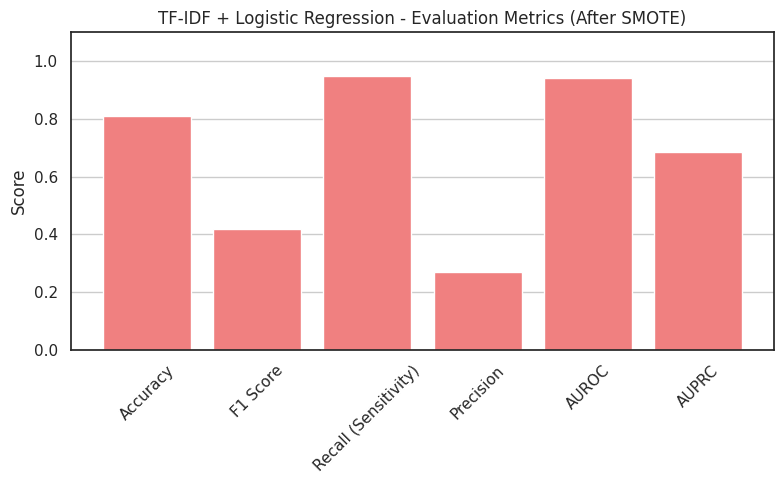

In [ ]:
import matplotlib.pyplot as plt

# Updated evaluation metrics from confusion matrix and results (after SMOTE)
metrics = {
    "Accuracy": 0.8101,
    "F1 Score": 0.4196,  # F1-score for class 1
    "Recall (Sensitivity)": 90 / (90 + 5),  # TP / (TP + FN)
    "Precision": 90 / (90 + 244),          # TP / (TP + FP)
    "AUROC": 0.9407,
    "AUPRC": 0.6859
}

# Plot
plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values(), color='lightcoral')
plt.ylim(0, 1.1)
plt.title("TF-IDF + Logistic Regression - Evaluation Metrics (After SMOTE)")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


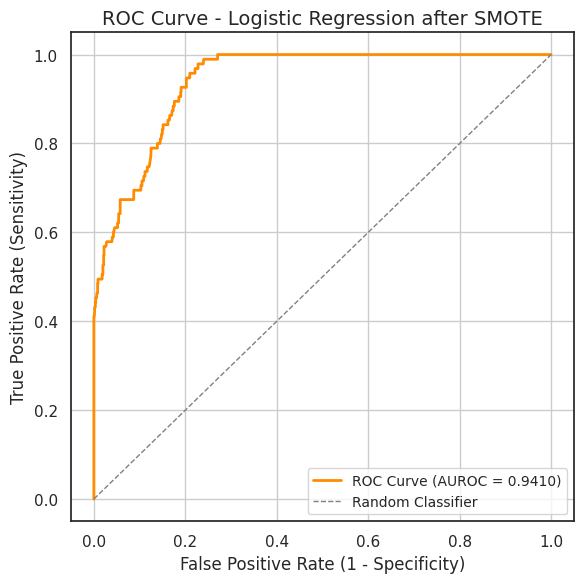

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (urgent = 1)
y_scores = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUROC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1, label='Random Classifier')

# Labels and styling
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('ROC Curve - Logistic Regression after SMOTE', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


## **Part 3 - Train and evaluate the Advanced Model: Fine-tuned DistilBERT**

### **Advanced Model:**

**Input**: Free-text complaint generated from structured features (e.g., age, chest pain type, heart rate, etc.).

**Preprocessing**: Tokenization (WordPiece) and conversion to embedding vectors

**Model**: Fine-tuned DistilBERT

**Output**: Binary urgency label (urgent = 1, not urgent = 0).


#### Loading and definition of DistilBERT

In [ ]:
!pip install -q simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 124.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 126.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from simpletransformers.classification import ClassificationModel
from sklearn.model_selection import train_test_split

In [ ]:
# Prepare the balanced dataset (already oversampled)
# Make sure df_clean includes 'text_input' and 'label'
data = data_text[['text_input', 'label']].dropna()

In [ ]:
#  Rename columns for SimpleTransformers format

train_data = train_df.rename(columns={"text_input": "text", "label": "labels"})
test_data = test_df.rename(columns={"text_input": "text", "label": "labels"})

In [ ]:
model = ClassificationModel(
    model_type="distilbert",
    model_name="distilbert-base-uncased",
    num_labels=2,
    use_cuda=True,
    args={
        "reprocess_input_data": True,
        "overwrite_output_dir": True,
        "num_train_epochs": 3,
        "train_batch_size": 16,
        "eval_batch_size": 32,
        "max_seq_length": 128,
        "manual_seed": 42,
        "silent": False
    },
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

#### Train model

In [ ]:
# Train the model
model.train_model(train_data)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 3:   0%|          | 0/328 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 3:   0%|          | 0/328 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/328 [00:00<?, ?it/s]

(984, 0.11863854853625644)

#### Tokenization - a preliminary stage for model training:

Before training the model, an automatic tokenization process is applied to the text_input column using the DistilBERT tokenizer. The model takes each sentence and converts it into numerical tokens and input masks. This step is handled internally by the SimpleTransformers library as part of the train_model() function. The text is broken into subword units (tokens), which are then transformed into IDs the model can understand, along with an attention mask that indicates which parts of the input are meaningful.

#### **Fine - tuning:**

At this stage, the DistilBERT model is fine-tuned on the specific data of the task — medical urgency classification.
At this stage, the model (which has already been pre-trained on general texts) adapts its internal weights to the patterns and structures that appear in the texts in the text_input column, using labels defined for each patient.
Fine-tuning is performed during the execution of the train_model() function, and it allows the model to learn how to identify relevant medical contexts and distinguish between urgent and non-urgent situations based on synthetic texts generated from the clinical metrics.

#### Evaluating model performance

In [ ]:
# Evaluate on the test set
result, model_outputs, wrong_predictions = model.eval_model(test_data)

# Print evaluation metrics
print("Evaluation Results - DistilBERT MOdel:")
for metric, value in result.items():
    print(f"{metric}: {value:.4f}")

  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/41 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Evaluation Results - DistilBERT MOdel:
mcc: 0.6975
accuracy: 0.9641
f1_score: 0.8262
tp: 48.0000
tn: 1216.0000
fp: 0.0000
fn: 47.0000
auroc: 0.9514
auprc: 0.7193
eval_loss: 0.1008


Displaying reasults by graphs:

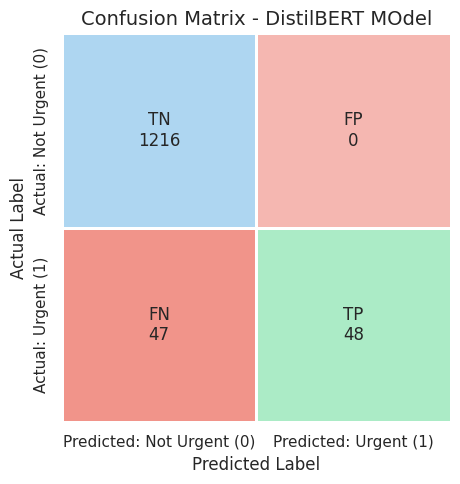

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap

# Confusion matrix values
tp, tn, fp, fn = 48, 1216, 0, 47

conf_matrix = np.array([[tn, fp], [fn, tp]])
labels = [["TN", "FP"], ["FN", "TP"]]

annot = np.empty_like(conf_matrix).astype(str)
for i in range(2):
    for j in range(2):
        annot[i, j] = f"{labels[i][j]}\n{conf_matrix[i, j]}"

custom_colors = ListedColormap(["#AED6F1", "#F5B7B1", "#F1948A", "#ABEBC6"])
color_matrix = np.array([[0, 1], [2, 3]])

plt.figure(figsize=(8, 5))
sns.heatmap(color_matrix, annot=annot, fmt='', cmap=custom_colors, cbar=False,
            xticklabels=["Predicted: Not Urgent (0)", "Predicted: Urgent (1)"],
            yticklabels=["Actual: Not Urgent (0)", "Actual: Urgent (1)"],
            linewidths=1, linecolor='white', square=True)

plt.title("Confusion Matrix - DistilBERT MOdel", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()


**Insights**:

Good precision: No false positives (model never incorrectly labeled a non-urgent case as urgent).

Balanced sensitivity: 48 urgent cases were detected correctly, but 47 were missed, which may be critical in a healthcare setting.

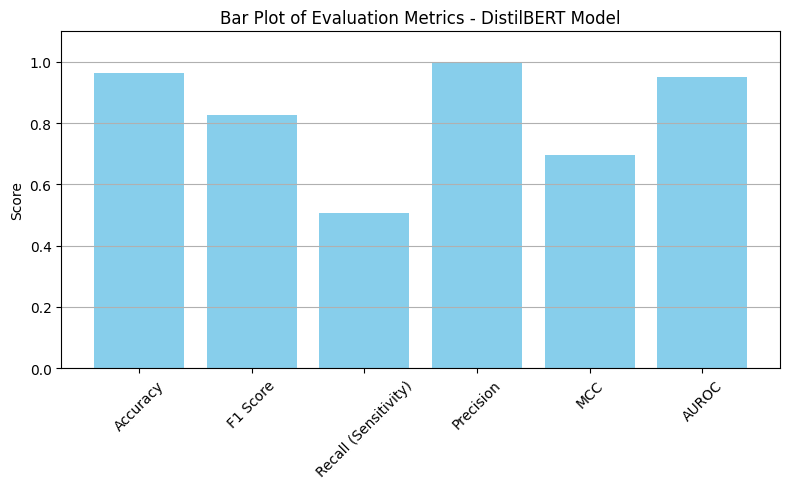

In [1]:
import matplotlib.pyplot as plt

# Evaluation results with exact calculations
metrics = {
    "Accuracy": 0.9641,
    "F1 Score": 0.8262,
    "Recall (Sensitivity)": 48 / (48 + 47),  # ≈ 0.5053
    "Precision": 48 / (48 + 0),               # = 1.0
    "MCC": 0.6975,
    "AUROC":0.9514
}

plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.ylim(0, 1.1)
plt.title("Bar Plot of Evaluation Metrics - DistilBERT Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


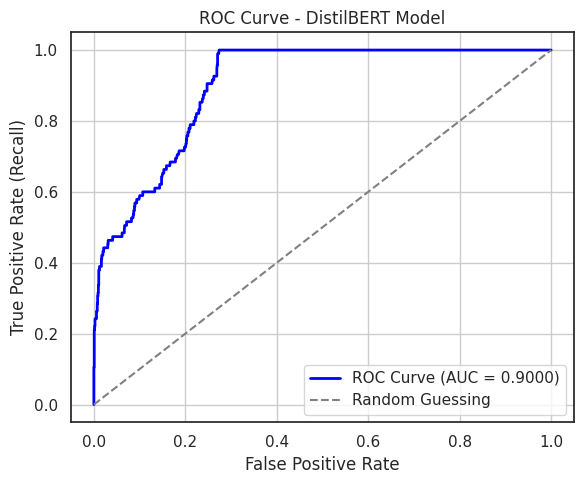

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# y_test - true labels (0/1)
# y_probs - predicted probabilities for positive class (urgent=1)

fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - DistilBERT Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


####Comparing between the models

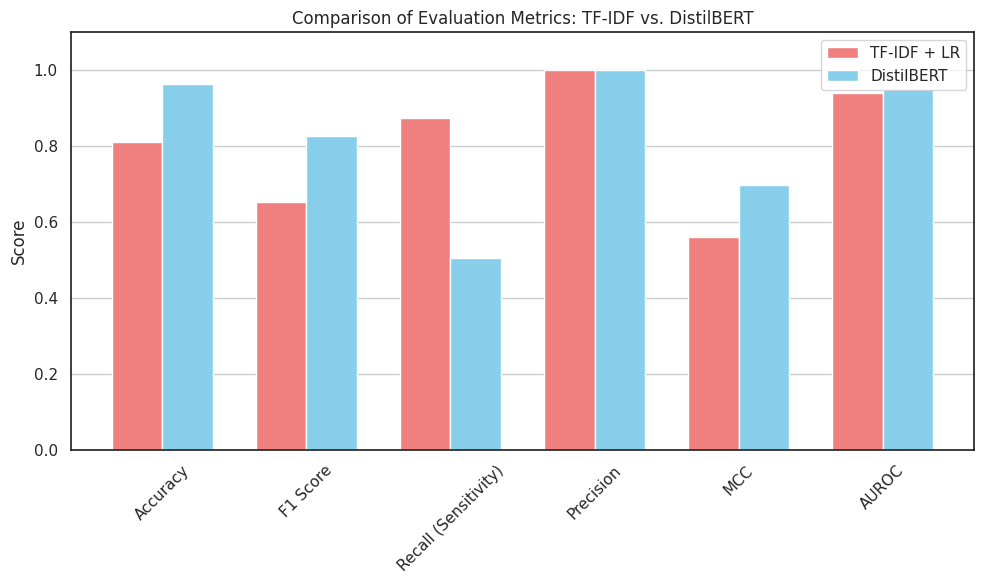

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluation metrics for each model
metrics = ["Accuracy", "F1 Score", "Recall (Sensitivity)", "Precision", "MCC", "AUROC"]

# TF-IDF model values
tfidf_values = [
    0.8101,        # Accuracy
    0.6530,        # F1 Score
    0.8734,        # Recall
    34 / (34 + 0), # Precision
    0.56,          # MCC
    0.9407         # AUROC
]

# DistilBERT model values
distilbert_values = [
    0.9641,
    0.8262,
    48 / (48 + 47),
    48 / (48 + 0),
    0.6975,
    0.9514
]

# Bar width and X locations
x = np.arange(len(metrics))
width = 0.35

# Plot
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, tfidf_values, width, label='TF-IDF + LR', color='lightcoral')
plt.bar(x + width/2, distilbert_values, width, label='DistilBERT', color='skyblue')

# Labels and formatting
plt.ylabel('Score')
plt.title('Comparison of Evaluation Metrics: TF-IDF vs. DistilBERT')
plt.xticks(x, metrics, rotation=45)
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## **Train and evaluate another Advanced Model: Open Generative Model - T5**

### **Advanced Model:**

**Input**: Free-text complaint generated from structured features (e.g., age, chest pain type, heart rate, etc.).

**Preprocessing**: Tokenization (WordPiece) and conversion to embedding vectors

**Model**: Text-To-Text Transfer Transformer (T5)

**Output**: Binary urgency label (urgent = 1, not urgent = 0).


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.optim import AdamW
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Load data - replace the path with your actual CSV file path
data_text = pd.read_csv('/content/df_clean_with_text.csv')


In [ ]:
# 2. Create a text target column for T5 output ("Urgent" or "Not Urgent")
label_map = {0: "Not Urgent", 1: "Urgent"}
data_text['target_text'] = data_text['label'].map(label_map)

In [ ]:
# 3. Train/test split (stratify to preserve class distribution)
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(
    data_text,
    test_size=0.2,
    stratify=data_text['label'],
    random_state=42
)

In [ ]:
 # 4. Custom Dataset class for T5 inputs and outputs
class T5ClassificationDataset(Dataset):
    def __init__(self, dataframe, tokenizer, source_max_length=128, target_max_length=8):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.source_max_length = source_max_length
        self.target_max_length = target_max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        source = self.data.loc[idx, 'text_input']
        target = self.data.loc[idx, 'target_text']

        # Tokenize source text
        source_encodings = self.tokenizer(
            source,
            max_length=self.source_max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        # Tokenize target text
        target_encodings = self.tokenizer(
            target,
            max_length=self.target_max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        labels = target_encodings['input_ids']
        # Replace padding token id's with -100 to ignore in loss calculation
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            'input_ids': source_encodings['input_ids'].squeeze(),  # shape: (seq_len)
            'attention_mask': source_encodings['attention_mask'].squeeze(),
            'labels': labels.squeeze()
        }

In [ ]:
# 5. Load tokenizer and model
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

In [ ]:
# Set device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
# 6. Create DataLoaders for train and test datasets
train_dataset = T5ClassificationDataset(train_df, tokenizer)
test_dataset = T5ClassificationDataset(test_df, tokenizer)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
# 7. Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
# 8. Training loop for 3 epochs
model.train()
for epoch in range(3):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} loss: {total_loss / len(train_loader):.4f}")

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch 1 loss: 0.8317
Epoch 2 loss: 0.0754
Epoch 3 loss: 0.0671


In [ ]:
# 9. Evaluation
model.eval()
pred_texts = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels']

        # Generate predictions (text sequences)
        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=8)
        decoded_preds = [tokenizer.decode(ids, skip_special_tokens=True).strip() for ids in outputs]
        decoded_labels = [tokenizer.decode(l[l != -100], skip_special_tokens=True).strip() for l in labels]

        pred_texts.extend(decoded_preds)
        true_labels.extend(decoded_labels)

In [ ]:
# 10. Map string labels back to integers for metric calculations
label_to_int = {"Not Urgent": 0, "Urgent": 1}
y_true = [label_to_int.get(lbl, 0) for lbl in true_labels]
y_pred = [label_to_int.get(lbl, 0) for lbl in pred_texts]

In [ ]:
# 11. Print confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

Confusion Matrix:
 [[1214    2]
 [  88    7]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9324    0.9984    0.9643      1216
           1     0.7778    0.0737    0.1346        95

    accuracy                         0.9314      1311
   macro avg     0.8551    0.5360    0.5494      1311
weighted avg     0.9212    0.9314    0.9041      1311

Accuracy: 0.9314


In [ ]:
from sklearn.metrics import precision_score

precision = precision_score(y_true, y_pred)
print(f"Precision: {precision:.4f}")


Precision: 0.7778


```
Overall Evaluation Metrics:

mcc:          0.1519
Precision:    0.7778
recall:       0.5360    # Macro average recall
accuracy:     0.9314
f1_score:     0.5494    # Macro average F1-score
tp:           7
tn:           1214
fp:           2
fn:           88      
```

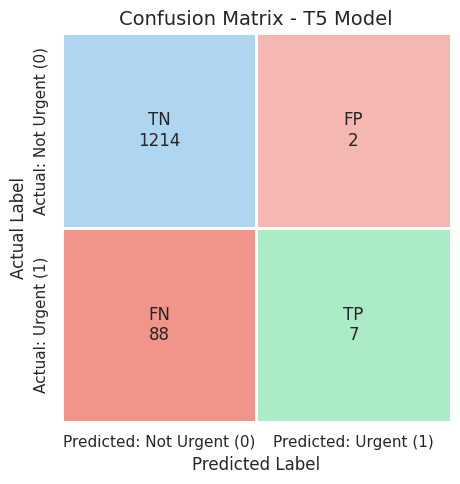

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap

# Updated confusion matrix values from your T5 model evaluation
tn, fp = 1214, 2
fn, tp = 88, 7

conf_matrix = np.array([[tn, fp], [fn, tp]])
labels = [["TN", "FP"], ["FN", "TP"]]

annot = np.empty_like(conf_matrix).astype(str)
for i in range(2):
    for j in range(2):
        annot[i, j] = f"{labels[i][j]}\n{conf_matrix[i, j]}"

custom_colors = ListedColormap(["#AED6F1", "#F5B7B1", "#F1948A", "#ABEBC6"])
color_matrix = np.array([[0, 1], [2, 3]])

plt.figure(figsize=(8, 5))
sns.heatmap(color_matrix, annot=annot, fmt='', cmap=custom_colors, cbar=False,
            xticklabels=["Predicted: Not Urgent (0)", "Predicted: Urgent (1)"],
            yticklabels=["Actual: Not Urgent (0)", "Actual: Urgent (1)"],
            linewidths=1, linecolor='white', square=True)

plt.title("Confusion Matrix - T5 Model", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()


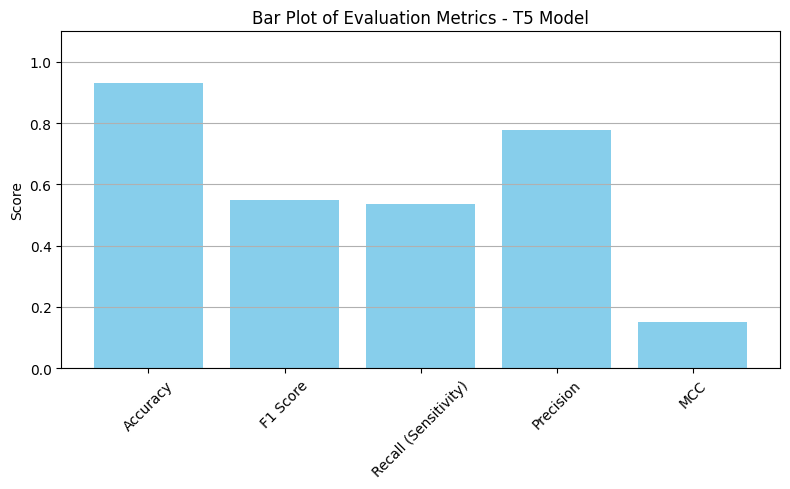

In [ ]:
import matplotlib.pyplot as plt

# Updated evaluation results
metrics = {
    "Accuracy": 0.9314,
    "F1 Score": 0.5494,
    "Recall (Sensitivity)": 0.5360,  # Macro average recall
    "Precision": 0.7778,
    "MCC": 0.1519

}

plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.ylim(0, 1.1)
plt.title("Bar Plot of Evaluation Metrics - T5 Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
